In [1]:
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import planetary_computer as pc
import geopandas as gpd
import h3
import pandas as pd

import rasterio
from rasterio import windows
from rasterio import features
from rasterio import warp
import rasterio.mask
from rasterio.enums import Resampling
from rasterio.merge import merge

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

from shapely.geometry import Point

from tqdm import tqdm

import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


2023-06-22 16:16:47 Configured OSMnx 1.1.2
2023-06-22 16:16:47 HTTP response caching is on


## Download data

### Municipality GeoDataFrame

(1, 6)


<AxesSubplot: >

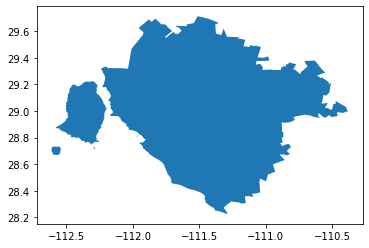

In [2]:
city = 'Hermosillo'
query = f"SELECT * FROM metropolis.metro_gdf WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')
print(mun_gdf.shape)
mun_gdf.plot()

### Hex-bins GeoDataFrame

(356, 2)


<AxesSubplot: >

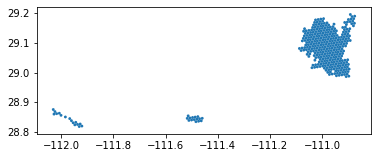

In [3]:
mpos = list(mun_gdf.CVEGEO.unique())

hex_ageb = gpd.GeoDataFrame()

schema = 'censo'
folder = 'hex_bins_pop_2020'

for m in mpos:
    query = f"SELECT hex_id_8,geometry FROM {schema}.{folder} WHERE \"CVEGEO\" LIKE \'{m}%%\'"
    hex_ageb = pd.concat([hex_ageb, 
                          aup.gdf_from_query(query, geometry_col='geometry')], 
                         ignore_index = True, axis = 0)

print(hex_ageb.shape)
hex_ageb.plot()

In [4]:
hex_ageb.head(2)

,hex_id_8,geometry
0,8848e5b6ddfffff,"POLYGON ((-111.00474 29.12146, -111.00565 29.1..."
1,8848564cedfffff,"POLYGON ((-110.94283 29.00836, -110.93816 29.0..."


In [7]:
hex_gdf = hex_ageb.copy()

Create hexagons for area with population at different resolutions

In [8]:
hex_gdf = hex_ageb.copy()
hex_gdf.rename(columns={'hex_id_8':'hex_id'}, inplace=True)
hex_gdf['res'] = 8

for r in range(9,12):
    
    hex_tmp = aup.create_hexgrid(hex_ageb, r)
    hex_tmp.rename(columns={f'hex_id_{r}':'hex_id'}, inplace=True)
    hex_tmp['res'] = r
    
    hex_gdf = pd.concat([hex_gdf, hex_tmp], 
        ignore_index = True, axis = 0)
    
    del hex_tmp

In [9]:
print(hex_gdf.shape)
hex_gdf.head(2)

(142400, 3)


,hex_id,geometry,res
0,8848e5b6ddfffff,"POLYGON ((-111.00474 29.12146, -111.00565 29.1...",8
1,8848564cedfffff,"POLYGON ((-110.94283 29.00836, -110.93816 29.0...",8


## Humidity index analysis

### Create boundaries for imagery download

In [10]:
# Reads mun_gdf GeoDataFrame as polygon
poly = hex_gdf.geometry
# Extracts coordinates from polygon as DataFrame
coord_val = poly.bounds
# Gets coordinates for bounding box
n = coord_val.maxy.max()
s = coord_val.miny.min()
e = coord_val.maxx.max()
w = coord_val.minx.min()

#### Generate polygon dictionary

In [11]:
area_of_interest = {
    "type": "Polygon",
    "coordinates": [
        [
            [e, s],
            [w, s],
            [w, n],
            [e, n],
            [e, s],
        ]
    ],
}

In [12]:
aoi = [w,s,e,n]

### Define time period for imagery

Since the api is limited to a max of 100 images, dates are divided in periods of 6 months.

In [13]:
time_of_interest = ["2020-01-01/2020-06-30"]

### Identify imagery

This section identifies satellite imagery that meets the requeirments for the Satellite (sentinel-2-l2a), area_of_interest, time_of_interest and limit for cloud cover (10%).

In [14]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

items = []

for t in time_of_interest:
    search = catalog.search(
        collections=["landsat-c2-l2"],
        bbox=aoi,
        datetime=t,
        query={"eo:cloud_cover": {"lt": 10},
              "platform": {"in": ["landsat-8"]}},
    )

    # Check how many items were returned
    items.extend(list(search.get_items()))
    
print(f"Returned {len(items)} Items")

Returned 11 Items


### Gather links for imagery bands

Identify download links for Near Infrared (nir) and SWIR bands for each date that meets the requierments.

In [15]:
selected_item = items[1]

print(
    f"Choosing {selected_item.id} from {selected_item.datetime.date()}"
    + f" with {selected_item.properties['eo:cloud_cover']}% cloud cover"
)

Choosing LC08_L2SP_035040_20200623_02_T1 from 2020-06-23 with 0.03% cloud cover


In [16]:
max_key_length = len(max(selected_item.assets, key=len))
for key, asset in selected_item.assets.items():
    print(f"{key.rjust(max_key_length)}: {asset.title}")

              qa: Surface Temperature Quality Assessment Band
             ang: Angle Coefficients File
             red: Red Band
            blue: Blue Band
            drad: Downwelled Radiance Band
            emis: Emissivity Band
            emsd: Emissivity Standard Deviation Band
            trad: Thermal Radiance Band
            urad: Upwelled Radiance Band
           atran: Atmospheric Transmittance Band
           cdist: Cloud Distance Band
           green: Green Band
           nir08: Near Infrared Band 0.8
          lwir11: Surface Temperature Band
          swir16: Short-wave Infrared Band 1.6
          swir22: Short-wave Infrared Band 2.2
         coastal: Coastal/Aerosol Band
         mtl.txt: Product Metadata File (txt)
         mtl.xml: Product Metadata File (xml)
        mtl.json: Product Metadata File (json)
        qa_pixel: Pixel Quality Assessment Band
       qa_radsat: Radiometric Saturation and Terrain Occlusion Quality Assessment Band
      qa_aerosol: Aeros

In [17]:
selected_item

ID: LC08_L2SP_035040_20200623_02_T1
"Bounding Box: [-111.76055223, 27.80395466, -109.38913467, 29.91775534]"
Datetime: 2020-06-23 17:52:34.050706+00:00
gsd: 30
created: 2022-05-06T17:24:41.390677Z
sci:doi: 10.5066/P9OGBGM6
datetime: 2020-06-23T17:52:34.050706Z
platform: landsat-8
proj:epsg: 32612
"proj:shape: [7781, 7631]"
description: Landsat Collection 2 Level-2


In [18]:
selected_item.properties

{'gsd': 30,
 'created': '2022-05-06T17:24:41.390677Z',
 'sci:doi': '10.5066/P9OGBGM6',
 'datetime': '2020-06-23T17:52:34.050706Z',
 'platform': 'landsat-8',
 'proj:epsg': 32612,
 'proj:shape': [7781, 7631],
 'description': 'Landsat Collection 2 Level-2',
 'instruments': ['oli', 'tirs'],
 'eo:cloud_cover': 0.03,
 'proj:transform': [30.0, 0.0, 426585.0, 0.0, -30.0, 3309915.0],
 'view:off_nadir': 0,
 'landsat:wrs_row': '040',
 'landsat:scene_id': 'LC80350402020175LGN00',
 'landsat:wrs_path': '035',
 'landsat:wrs_type': '2',
 'view:sun_azimuth': 99.46083784,
 'landsat:correction': 'L2SP',
 'view:sun_elevation': 68.65108968,
 'landsat:cloud_cover_land': 0.03,
 'landsat:collection_number': '02',
 'landsat:collection_category': 'T1'}

In [19]:
def find_asset_by_band_common_name(item, common_name):
    for asset in item.assets.values():
        asset_bands = eo.ext(asset).bands
        if asset_bands and asset_bands[0].common_name == common_name:
            return asset
    raise KeyError(f"{common_name} band not found")

In [24]:
assets_hrefs = {selected_item.datetime.date() : pc.sign(find_asset_by_band_common_name(selected_item,'red').href)}

In [25]:
assets_hrefs

{datetime.date(2020, 6, 23): 'https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2020/035/040/LC08_L2SP_035040_20200623_20200823_02_T1/LC08_L2SP_035040_20200623_20200823_02_T1_SR_B4.TIF?st=2023-06-21T22%3A18%3A29Z&se=2023-06-22T23%3A03%3A29Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-06-22T18%3A46%3A01Z&ske=2023-06-29T18%3A46%3A01Z&sks=b&skv=2021-06-08&sig=f5LdvuEkGbk/9bA94lJ%2BhIpuaCE3F3A2dZTKpTgyYaE%3D'}

In [ ]:
band_info["scale"]

In [ ]:
src = rasterio.open(assets)

In [35]:
bands_of_interest = [ "lwir"]
data = odc.stac.stac_load(
    [selected_item], bands=bands_of_interest, bbox=aoi
).isel(time=0)
data

Aborting load due to failure while reading: https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/etm/2020/029/045/LE07_L2SP_029045_20200317_20200822_02_T1/LE07_L2SP_029045_20200317_20200822_02_T1_ST_B6.TIF:1


RasterioIOError: HTTP response code: 404

In [31]:
band_info = selected_item.assets["lwir11"].extra_fields["raster:bands"][0]
band_info

{'unit': 'kelvin',
 'scale': 0.00341802,
 'nodata': 0,
 'offset': 149.0,
 'data_type': 'uint16',
 'spatial_resolution': 30}

In [23]:
temperature = data["lwir"].astype(float)
temperature *= band_info["scale"]
temperature += band_info["offset"]
temperature[:5, :5]

NameError: name 'data' is not defined

In [15]:
def find_asset_by_band_common_name(item, common_name):
    for asset in item.assets.values():
        asset_bands = eo.ext(asset).bands
        if asset_bands and asset_bands[0].common_name == common_name:
            return asset
    raise KeyError(f"{common_name} band not found")

In [16]:
vegetation = 'nir'
humidity = 'swir16'

In [17]:
assets_hrefs = {}

for i in items:
    if i.datetime.date() in list(assets_hrefs.keys()):
        assets_hrefs[i.datetime.date()][vegetation].append(pc.sign(find_asset_by_band_common_name(i,vegetation).href))
        assets_hrefs[i.datetime.date()][humidity].append(pc.sign(find_asset_by_band_common_name(i,humidity).href))
    else:
        assets_hrefs[i.datetime.date()] = {vegetation:[],
                                          humidity:[]}
        assets_hrefs[i.datetime.date()][vegetation].append(pc.sign(find_asset_by_band_common_name(i,vegetation).href))
        assets_hrefs[i.datetime.date()][humidity].append(pc.sign(find_asset_by_band_common_name(i,humidity).href))

In [18]:

max_links_len = 0

# first determine max amount of satellite data 
for k_date in list(assets_hrefs.keys()):
    # gather data from first band in dictionary - the max value should be the same in all bands
    k_band = list(assets_hrefs[k_date].keys())[0]
    # compare len of that band to max
    if len(assets_hrefs[k_date][k_band]) > max_links_len:
        # if its higher this is the new high value
        max_links_len = len(assets_hrefs[k_date][k_band])
        
# iterate and remove dates without sufficient data
for k_date in list(assets_hrefs.keys()):
    # gather data from first band in dictionary - the max value should be the same in all bands
    k_band = list(assets_hrefs[k_date].keys())[0]
    # compare len of that band to max
    if len(assets_hrefs[k_date][k_band]) < max_links_len:
        # if len is less it indicates that is missing data
        # remove date with missing data
        assets_hrefs.pop(k_date)

In [19]:
df_dates = pd.DataFrame.from_dict(assets_hrefs, orient='Index').reset_index().rename(columns={'index':'date'})
df_dates['date'] = pd.to_datetime(df_dates['date']).dt.date
df_dates['year'] = df_dates.apply(lambda row: row['date'].year, axis=1)
df_dates['month'] = df_dates.apply(lambda row: row['date'].month, axis=1)
print(df_dates.shape)
df_dates.head(4)

(86, 5)


,date,nir,swir16,year,month
0,2020-05-27,[https://sentinel2l2a01.blob.core.windows.net/...,[https://sentinel2l2a01.blob.core.windows.net/...,2020,5
1,2020-05-22,[https://sentinel2l2a01.blob.core.windows.net/...,[https://sentinel2l2a01.blob.core.windows.net/...,2020,5
2,2020-05-17,[https://sentinel2l2a01.blob.core.windows.net/...,[https://sentinel2l2a01.blob.core.windows.net/...,2020,5
3,2020-05-12,[https://sentinel2l2a01.blob.core.windows.net/...,[https://sentinel2l2a01.blob.core.windows.net/...,2020,5


In [20]:
df_dates_filtered = pd.DataFrame()

for y in df_dates['year'].unique():
    for m in df_dates.loc[df_dates['year']==y,'month'].unique():
        df_dates_filtered = pd.concat([df_dates_filtered,
                                     df_dates.loc[(df_dates['year']==y)&
                                                  (df_dates['month']==m)].sample(1)],
                                      ignore_index=True)
print(df_dates_filtered.shape)
df_dates_filtered.head(4)

(24, 5)


,date,nir,swir16,year,month
0,2020-05-17,[https://sentinel2l2a01.blob.core.windows.net/...,[https://sentinel2l2a01.blob.core.windows.net/...,2020,5
1,2020-04-17,[https://sentinel2l2a01.blob.core.windows.net/...,[https://sentinel2l2a01.blob.core.windows.net/...,2020,4
2,2020-03-28,[https://sentinel2l2a01.blob.core.windows.net/...,[https://sentinel2l2a01.blob.core.windows.net/...,2020,3
3,2020-02-17,[https://sentinel2l2a01.blob.core.windows.net/...,[https://sentinel2l2a01.blob.core.windows.net/...,2020,2


In [21]:
# create full range time dataframe
df_tmp_dates = pd.DataFrame() # temporary date dataframe
df_tmp_dates['date'] = pd.date_range(start = "2020-01-01",   
                           periods = 30,   # there are 30 periods because range from satelite img goes from 01-01-2020 - 30-06-2022
                           freq = "M") # create date range
# extract year and month
df_tmp_dates['year'] = df_tmp_dates.apply(lambda row: row['date'].year, axis=1)
df_tmp_dates['month'] = df_tmp_dates.apply(lambda row: row['date'].month, axis=1)

# remove date column for merge
df_tmp_dates.drop(columns=['date'], inplace=True)

df_complete_dates = df_tmp_dates.merge(df_dates_filtered, left_on=['year','month'],
                                      right_on=['year','month'], how='left')

# remove date 
df_complete_dates.drop(columns='date', inplace=True)

missing_months = df_complete_dates.nir.isna().sum()
print(missing_months)
df_complete_dates.head(2)

6


,year,month,nir,swir16
0,2020,1,[https://sentinel2l2a01.blob.core.windows.net/...,[https://sentinel2l2a01.blob.core.windows.net/...
1,2020,2,[https://sentinel2l2a01.blob.core.windows.net/...,[https://sentinel2l2a01.blob.core.windows.net/...


## Data gathering and filter

Bands to analyze

In [12]:
band_name_list = ['nir','swir16']

In [13]:
def link_dict(band_name_list):
    
    assets_hrefs = {}

    for i in items:
        if i.datetime.date() in list(assets_hrefs.keys()):
            for b in band_name_list:
                assets_hrefs[i.datetime.date()][b].append(pc.sign(find_asset_by_band_common_name(i,b).href))
        else:
            assets_hrefs[i.datetime.date()] = {}
            for b in band_name_list:
                assets_hrefs[i.datetime.date()].update({b:[]})
                assets_hrefs[i.datetime.date()][b].append(pc.sign(find_asset_by_band_common_name(i,b).href))
                
    return assets_hrefs

In [14]:
assets_hrefs = link_dict(band_name_list)

Remove dates without insuficcient data

In [15]:
def filter_links(assets_hrefs):
    max_links_len = 0

    # first determine max amount of satellite data 
    for k_date in list(assets_hrefs.keys()):
        # gather data from first band in dictionary - the max value should be the same in all bands
        k_band = list(assets_hrefs[k_date].keys())[0]
        # compare len of that band to max
        if len(assets_hrefs[k_date][k_band]) > max_links_len:
            # if its higher this is the new high value
            max_links_len = len(assets_hrefs[k_date][k_band])

    # iterate and remove dates without sufficient data
    for k_date in list(assets_hrefs.keys()):
        # gather data from first band in dictionary - the max value should be the same in all bands
        k_band = list(assets_hrefs[k_date].keys())[0]
        # compare len of that band to max
        if len(assets_hrefs[k_date][k_band]) < max_links_len:
            # if len is less it indicates that is missing data
            # remove date with missing data
            assets_hrefs.pop(k_date)
    
    return assets_hrefs

In [16]:
assets_hrefs = filter_links(assets_hrefs)

Filter data by month

In [17]:
def df_date_links(assets_hrefs):
    # dictionary to dataframe
    df_dates = pd.DataFrame.from_dict(assets_hrefs, orient='Index').reset_index().rename(columns={'index':'date'})
    df_dates['date'] = pd.to_datetime(df_dates['date']).dt.date
    df_dates['year'] = df_dates.apply(lambda row: row['date'].year, axis=1)
    df_dates['month'] = df_dates.apply(lambda row: row['date'].month, axis=1)
    
    df_dates_filtered = pd.DataFrame()
    
    # keep only one data point by month
    for y in df_dates['year'].unique():
        for m in df_dates.loc[df_dates['year']==y,'month'].unique():
            df_dates_filtered = pd.concat([df_dates_filtered,
                                         df_dates.loc[(df_dates['year']==y)&
                                                      (df_dates['month']==m)].sample(1)],
                                          ignore_index=True)
    
    # create full range time dataframe
    df_tmp_dates = pd.DataFrame() # temporary date dataframe
    df_tmp_dates['date'] = pd.date_range(start = "2020-01-01",   
                               periods = 30,   # there are 30 periods because range from satelite img goes from 01-01-2020 - 30-06-2022
                               freq = "M") # create date range
    # extract year and month
    df_tmp_dates['year'] = df_tmp_dates.apply(lambda row: row['date'].year, axis=1)
    df_tmp_dates['month'] = df_tmp_dates.apply(lambda row: row['date'].month, axis=1)

    # remove date column for merge
    df_tmp_dates.drop(columns=['date'], inplace=True)

    df_complete_dates = df_tmp_dates.merge(df_dates_filtered, left_on=['year','month'],
                                          right_on=['year','month'], how='left')

    # remove date 
    df_complete_dates.drop(columns='date', inplace=True)
    df_complete_dates.sort_values(by=['year','month'], inplace=True)
    
    missing_months = df_complete_dates.nir.isna().sum()
    
    return df_complete_dates, missing_months

In [18]:
df_complete_dates, missing_months = df_date_links(assets_hrefs)

In [19]:
print(df_complete_dates.shape)
df_complete_dates.head(4)

(30, 4)


,year,month,nir,swir16
0,2020,1,[https://sentinel2l2a01.blob.core.windows.net/...,[https://sentinel2l2a01.blob.core.windows.net/...
1,2020,2,[https://sentinel2l2a01.blob.core.windows.net/...,[https://sentinel2l2a01.blob.core.windows.net/...
2,2020,3,[https://sentinel2l2a01.blob.core.windows.net/...,[https://sentinel2l2a01.blob.core.windows.net/...
3,2020,4,[https://sentinel2l2a01.blob.core.windows.net/...,[https://sentinel2l2a01.blob.core.windows.net/...


## Processing pipeline

In [23]:
def mosaic_raster(raster_asset_list, tmp_dir='tmp/', upscale=False):
    src_files_to_mosaic = []

    for assets in raster_asset_list:
        src = rasterio.open(assets)
        src_files_to_mosaic.append(src)
        
    mosaic, out_trans = merge(src_files_to_mosaic) # mosaic raster
    
    meta = src.meta
    
    if upscale:
        # save raster
        out_meta = src.meta

        out_meta.update({"driver": "GTiff",
                         "dtype": 'float32',
                         "height": mosaic.shape[1],
                         "width": mosaic.shape[2],
                         "transform": out_trans})
        # write raster
        with rasterio.open(tmp_dir+"mosaic_upscale.tif", "w", **out_meta) as dest:
            dest.write(mosaic)

            dest.close()
        # read and upscale
        with rasterio.open(tmp_dir+"mosaic_upscale.tif", "r") as ds:

            upscale_factor = 1/2

            mosaic = ds.read(
                        out_shape=(
                            ds.count,
                            int(ds.height * upscale_factor),
                            int(ds.width * upscale_factor)
                        ),
                        resampling=Resampling.bilinear
                    )

        ds.close()
    src.close()
    
    return mosaic, out_trans, meta

### Create NDMI files

In [ ]:
df_len = df_complete_dates.copy()

for i in tqdm(range(len(df_len)), position=0, leave=True):
    
    if type(df_len.iloc[i].nir)!=list:
        continue
    
    # mosaic by raster band
    try:
        mosaic_nir, _,_ = mosaic_raster(df_complete_dates.iloc[i].nir, upscale=True)
        mosaic_swir, out_trans_swir, out_meta = mosaic_raster(df_complete_dates.iloc[i].swir16)
    except:
        
        print(i)
        
        assets_hrefs = link_dict(band_name_list)
        assets_hrefs = filter_links(assets_hrefs)
        df_complete_dates, missing_months = df_date_links(assets_hrefs)
        
        mosaic_nir, _,_ = mosaic_raster(df_complete_dates.iloc[i].nir, upscale=True)
        mosaic_swir, out_trans_swir, out_meta = mosaic_raster(df_complete_dates.iloc[i].swir16)
    
    mosaic_nir = mosaic_nir.astype(float)
    mosaic_swir = mosaic_swir.astype(float)
    
    ndmi = (mosaic_nir-mosaic_swir)/(mosaic_nir+mosaic_swir)
    
    out_meta.update({"driver": "GTiff",
                 "dtype": 'float32',
                 "height": ndmi.shape[1],
                 "width": ndmi.shape[2],
                 "transform": out_trans_swir})

    # gather month and year from df to save ndmi
    month_ = df_complete_dates.iloc[i]['month']
    year_ = df_complete_dates.iloc[i]['year']

    with rasterio.open(f"tmp/ndmi/ndmi_{month_}_{year_}.tif", "w", **out_meta) as dest:
        dest.write(ndmi)

        dest.close()

  0%|                                                                                                                                             | 0/30 [00:00<?, ?it/s]

0


### NDMI to Hexagon

In [8]:
ndmi_file = ''

In [9]:
def clean_mask(geom, dataset=ndmi_file, **mask_kw):
    mask_kw.setdefault('crop', True)
    mask_kw.setdefault('all_touched', True)
    mask_kw.setdefault('filled', False)
    masked, mask_transform = rasterio.mask.mask(dataset=dataset, shapes=(geom,),
                                  **mask_kw)
    return masked

In [22]:
# create empty geodataframe to save ndmi by date
hex_ndmi = gpd.GeoDataFrame()

for d in tqdm(range(len(df_complete_dates)),position=0,leave=True):
    
    month_ = df_complete_dates.iloc[d]['month']
    year_ = df_complete_dates.iloc[d]['year']
    
    r = 8
    hex_tmp = hex_gdf.loc[hex_gdf.res==r].copy()
    
    if type(df_complete_dates.iloc[d].nir)==list:
                
        # read ndmi file
        ndmi_file = rasterio.open(f"tmp/ndmi/ndmi_{month_}_{year_}.tif")
        
        hex_tmp = hex_tmp.to_crs(ndmi_file.crs)
        
        try:

            hex_tmp['ndmi'] = hex_tmp.geometry.apply(lambda geom: clean_mask(geom, ndmi_file)).apply(np.ma.mean)
        except:
            hex_tmp['ndmi'] = np.nan
    
    else:
        hex_tmp['ndmi'] = np.nan
        
    hex_tmp['month'] = month_
    hex_tmp['year'] = year_
    
    hex_tmp = hex_tmp.to_crs("EPSG:4326")
    
    # concatenate into single geodataframe
    hex_ndmi = pd.concat([hex_ndmi, hex_tmp], 
        ignore_index = True, axis = 0)
    
    del hex_tmp

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:43<00:00,  1.46s/it]


In [23]:
print(hex_ndmi.shape)
hex_ndmi.head(4)

(35610, 6)


,hex_id,geometry,res,ndmi,month,year
0,8849abc9ebfffff,"POLYGON ((-103.61319 20.42802, -103.61772 20.4...",8,0.021569,1,2020
1,8849abc9e3fffff,"POLYGON ((-103.61374 20.43321, -103.61319 20.4...",8,0.229900,1,2020
2,8849abc999fffff,"POLYGON ((-103.64928 20.44809, -103.65381 20.4...",8,-0.077834,1,2020
3,8849abc9e7fffff,"POLYGON ((-103.59961 20.43722, -103.60414 20.4...",8,-0.053955,1,2020


## Interpolate

In [24]:
hex_ndmi.ndmi.isna().sum()

9049

In [36]:
hex_ndmi_test = hex_ndmi.copy()

In [41]:
hex_ndmi_test = hex_ndmi.copy()

def f(x):
    return x['ndmi'].interpolate()

#Finally:
hex_ndmi_test=hex_ndmi_test.groupby('hex_id').apply(f)

In [46]:
hex_ndmi_test.reset_index().set_index('level_1')

,hex_id,ndmi
level_1,,
1155,88498c8649fffff,0.022860
2342,88498c8649fffff,-0.044466
3529,88498c8649fffff,-0.063492
4716,88498c8649fffff,-0.087446
5903,88498c8649fffff,-0.065478
...,...,...
29684,8849abc9edfffff,-0.005931
30871,8849abc9edfffff,-0.018537
32058,8849abc9edfffff,-0.033473


In [75]:
for idx in hex_ndmi.hex_id.unique():
    hex_ndmi.loc[hex_ndmi.hex_id==idx, 'ndmi'] = hex_ndmi.loc[hex_ndmi.hex_id==idx, 'ndmi'].interpolate()

In [76]:
hex_ndmi.ndmi.isna().sum()

0

## Data analysis

In [77]:
hex_ndmi_analysis = hex_ndmi[['hex_id','geometry','res']].drop_duplicates().copy()
print(hex_ndmi_analysis.shape)
hex_ndmi_analysis.head(4)

(116113, 3)


,hex_id,geometry,res
0,8a49abc9ea1ffff,"POLYGON ((-103.61199 20.42326, -103.61135 20.4...",10
1,8a49abc9eacffff,"POLYGON ((-103.61303 20.42653, -103.61239 20.4...",10
2,8a49abc9ea17fff,"POLYGON ((-103.61119 20.42222, -103.61054 20.4...",10
3,8a49abc9c4dffff,"POLYGON ((-103.61564 20.41841, -103.61499 20.4...",10


In [ ]:
for idx in list(hex_ndmi_analysis.hex_id.unique()):
    hex_ndmi_analysis.loc[hex_ndmi_analysis.hex_id==idx, 'ndmi_max'] = hex_ndmi.loc[hex_ndmi.hex_id==idx, 'ndmi'].max()
    hex_ndmi_analysis.loc[hex_ndmi_analysis.hex_id==idx, 'ndmi_min'] = hex_ndmi.loc[hex_ndmi.hex_id==idx, 'ndmi'].min()
    hex_ndmi_analysis.loc[hex_ndmi_analysis.hex_id==idx, 'ndmi_mean'] = hex_ndmi.loc[hex_ndmi.hex_id==idx, 'ndmi'].mean()

hex_ndmi_analysis['ndmi_diff'] = hex_ndmi_analysis['ndmi_min'] - hex_ndmi_analysis['ndmi_max']

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

hex_ndmi_analysis.plot('ndmi_mean', legend=True, ax=ax)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

hex_ndmi_analysis.plot('ndmi_diff', legend=True, ax=ax)